# The Chinese Restaurants Battle in Hong Kong (Week 2) with Code

##### Bryan Kwok - 2020/11/06





## Introduction

People always come up with a place in the world with various cultures and languages in a place, which is Hong Kong. Although the size of Hong Kong is relatively small to some countries in Europe, there are over 7.5 million people in 18 districts here. This is a place inherited ancient Chinese culture and experienced a period of western colonial influence. 

There are so many good restaurants in Hong Kong, including Chinese, Japanese, Western, etc. Many investors in the world would like to build up their reputation in Hong Kong and set up a restaurant here. However, it is never easy to survive in this battlefield without research and delicious food. Chinese restaurants will be one of the good choices for HongKongers based on its appealing dishes and fresh ingredients.

In this project, we will try to investigate the neighborhoods in the districts of Hong Kong.  By the end, we will solve the problems, and tell you the good choice of opening a Chinese restaurant in Hong Kong.

## Business Problem

The objective of this project is to find out the optimum place in Hong Kong to open a new Chinese restaurant. For investors, it would be critical for them to know which places are important to have the new restaurants. It may be also important for them to set up a restaurant with similar dishes around the districts. Some districts may probably have more good Chinese restaurants compared to the others. This may help them stand out and build the reputation. 

For us, it is always helpful to have more information of good Chinese restaurants. This project will also provide a good insight for audience to understand the distribution of Chinese restaurants in Hong Kong.


### Problem Statement

1. Where are the best districts for Chinese cuisine in Hong Kong? 
2. In disticts should the investor open a Chinese restaurant to have the best chance of being successful? 
3. Where can we go in Hong Kong to have the best Chinese food?

## Data

To solve the business problem, the following data is required for analysis.

- The data of Hong Kong containing the districts name
- Latitude and Longitude coordinates of those districts
- Venue places with the information of location, name, categories



## Methodology

- Firstly, the data will be collected from _https://www.geodatos.net/en/coordinates/hong-kong_ and cleaned for the later process.

- Then FourSquare will be used to locate the venues in those districts. Then the number and frequencies of restaurant types will be recorded and summarized into the dataframe.

- Data will be sorted based on rankings. At the end, the data will be visually visualized by the graphics using the Python libraries.

In [2]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

#print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
#Getting the geographical coordinates from csv files
myhk_df = pd.read_csv('hk_geog.csv')
myhk_df.head()

,City,Coordinates
0,Hong Kong,"22.27832, 114.17469"
1,Kowloon,"22.31667, 114.18333"
2,Tsuen Wan,"22.37137, 114.11329"
3,Yuen Long Kau Hui,"22.45, 114.03333"
4,Tung Chung,"22.28783, 113.94243"


In [5]:
myhk_df[['Latitude','Longitude']] = myhk_df['Coordinates'].str.split(', ',expand=True)
#myhk_df = myhk_df[['City','Latitude','Longitude']]

myhk_df.head()
#myhk_df = myhk_df.convert_objects(convert_numeric=True)
myhk_df['Latitude'] = myhk_df['Latitude'].astype('float')
myhk_df['Longitude'] = myhk_df['Longitude'].astype('float')
myhk_df.head()

,City,Coordinates,Latitude,Longitude
0,Hong Kong,"22.27832, 114.17469",22.27832,114.17469
1,Kowloon,"22.31667, 114.18333",22.31667,114.18333
2,Tsuen Wan,"22.37137, 114.11329",22.37137,114.11329
3,Yuen Long Kau Hui,"22.45, 114.03333",22.45000,114.03333
4,Tung Chung,"22.28783, 113.94243",22.28783,113.94243


In [6]:
print('The dataframe has {} districts.'.format(
        len(myhk_df['City'].unique()),
        myhk_df.shape[0]
    )
)

The dataframe has 17 districts.


In [55]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [8]:
column_names=['City','ID','Name']
chinese_rest_hk=pd.DataFrame(columns=column_names)
count = 1
for row in myhk_df.values.tolist():
    City, Coordinates, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants = venues[venues['Category']=='Chinese Restaurant']
    print('(',count,'/',len(myhk_df),')','Chinese Restaurants in '+ City +', '+':'+str(len(chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_hk = chinese_rest_hk.append({'City': City,
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 17 ) Chinese Restaurants in Hong Kong, :2
['Hong Kong', '22.27832, 114.17469', 22.27832, 114.17469]
( 2 / 17 ) Chinese Restaurants in Kowloon, :0
['Kowloon', '22.31667, 114.18333', 22.31667, 114.18333]
( 3 / 17 ) Chinese Restaurants in Tsuen Wan, :3
['Tsuen Wan', '22.37137, 114.11329', 22.37137, 114.11329]
( 4 / 17 ) Chinese Restaurants in Yuen Long Kau Hui, :0
['Yuen Long Kau Hui', '22.45, 114.03333', 22.45, 114.03333]
( 5 / 17 ) Chinese Restaurants in Tung Chung, :3
['Tung Chung', '22.28783, 113.94243', 22.28783, 113.94243]
( 6 / 17 ) Chinese Restaurants in Sha Tin, :0
['Sha Tin', '22.38333, 114.18333', 22.38333, 114.18333]
( 7 / 17 ) Chinese Restaurants in Tuen Mun, :0
['Tuen Mun', '22.39175, 113.97157', 22.39175, 113.97157]
( 8 / 17 ) Chinese Restaurants in Tai Po, :4
['Tai Po', '22.45007, 114.16877', 22.45007, 114.16877]
( 9 / 17 ) Chinese Restaurants in Sai Kung, :0
['Sai Kung', '22.38333, 114.26667', 22.38333, 114.26667]
( 10 / 17 ) Chinese Restaurants in Yung Shue Wan, :2

In [9]:
# Save the information so far to a .csv file due to limited calls on FourSquare
chinese_rest_hk.to_csv('chinese_rest_hk.csv')

In [10]:
chinese_hk = pd.read_csv('chinese_rest_hk.csv')
chinese_hk

,Unnamed: 0,City,ID,Name
0,0,Hong Kong,4b67b864f964a520f15b2be3,Liu Yuan Pavilion (留園雅敘)
1,1,Hong Kong,4bb2cdfb715eef3b41bf85bb,Trusty Congee King (靠得住粥麵小館)
2,2,Tsuen Wan,4d400e3789616dcb823f00b5,Nice Capital Restaurant (麗都讌客)
3,3,Tsuen Wan,4be40308b02ec9b684c450c0,Sportful Garden Restaurant (陶源酒家)
4,4,Tsuen Wan,4e33f15062e1733d7aa708c4,The Great Restaurant (一品雞煲火鍋)
5,5,Tung Chung,4d16c7aab15cb1f737efaf21,Super Super 一粥麵
6,6,Tung Chung,4c936bcd1221b1f768cf19e2,Federal Palace (Federal Palace 聯邦皇宮)
7,7,Tung Chung,5243fe4711d27f0bc9d8d08d,Old Cheng Du 老城都
8,8,Tai Po,4e89b10d6c25bf8636514f83,China House (家傳滬曉)
9,9,Tai Po,4bf0eb5fb315c9b6c97f93ff,Kwan Kee (群記清湯腩)


In [11]:
chinese_hk.columns = ['Index','City','ID','Name']
chinese_hk.shape

(26, 4)

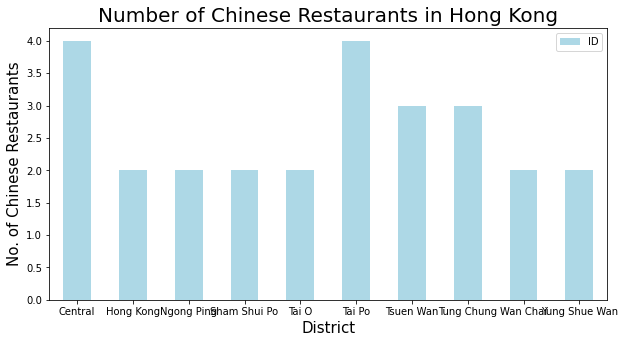

In [12]:
chinese_rest_hk.groupby('City')['ID'].count().plot.bar(figsize=(10,5), color='lightblue')
plt.title('Number of Chinese Restaurants in Hong Kong', fontsize = 20)
plt.xlabel('District', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()



Now we will get the ranking of each restaurant for further analysis.


In [13]:
chinese_hk

,Index,City,ID,Name
0,0,Hong Kong,4b67b864f964a520f15b2be3,Liu Yuan Pavilion (留園雅敘)
1,1,Hong Kong,4bb2cdfb715eef3b41bf85bb,Trusty Congee King (靠得住粥麵小館)
2,2,Tsuen Wan,4d400e3789616dcb823f00b5,Nice Capital Restaurant (麗都讌客)
3,3,Tsuen Wan,4be40308b02ec9b684c450c0,Sportful Garden Restaurant (陶源酒家)
4,4,Tsuen Wan,4e33f15062e1733d7aa708c4,The Great Restaurant (一品雞煲火鍋)
5,5,Tung Chung,4d16c7aab15cb1f737efaf21,Super Super 一粥麵
6,6,Tung Chung,4c936bcd1221b1f768cf19e2,Federal Palace (Federal Palace 聯邦皇宮)
7,7,Tung Chung,5243fe4711d27f0bc9d8d08d,Old Cheng Du 老城都
8,8,Tai Po,4e89b10d6c25bf8636514f83,China House (家傳滬曉)
9,9,Tai Po,4bf0eb5fb315c9b6c97f93ff,Kwan Kee (群記清湯腩)


In [14]:
column_names=['City', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_hk=pd.DataFrame(columns=column_names)

count=1
for row in chinese_hk.values.tolist():
    Index, City ,ID ,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id ,name ,likes ,rating ,tips =[0]*5
    print('(',count,'/',len(chinese_rest_hk),')','processed')
    chinese_rest_stats_hk = chinese_rest_stats_hk.append({'City': City, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_hk.tail()

{'meta': {'code': 200, 'requestId': '5fa5010c7fff582585ab23c2'}, 'response': {'venue': {'id': '4b67b864f964a520f15b2be3', 'name': 'Liu Yuan Pavilion (留園雅敘)', 'contact': {'phone': '+85228042000', 'formattedPhone': '+852 2804 2000'}, 'location': {'address': '3/F, The Broadway, 54-62 Lockhart Rd', 'lat': 22.278207847994896, 'lng': 114.1708592923482, 'labeledLatLngs': [{'label': 'display', 'lat': 22.278207847994896, 'lng': 114.1708592923482}], 'cc': 'HK', 'neighborhood': 'Wan Chai', 'city': '灣仔', 'state': '灣仔區', 'country': '香港', 'formattedAddress': ['3/F, The Broadway, 54-62 Lockhart Rd', '灣仔區', '香港']}, 'canonicalUrl': 'https://foursquare.com/v/liu-yuan-pavilion/4b67b864f964a520f15b2be3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 24}, 'price':

,City,ID,Name,Likes,Rating,Tips
21,Central,4b91df7ef964a520eedc33e3,Cuisine Cuisine (國金軒),41,7.2,20
22,Wan Chai,4b0588d8f964a520d5dc22e3,One Harbour Road (港灣壹號),40,8.7,17
23,Wan Chai,4b67b864f964a520f15b2be3,Liu Yuan Pavilion (留園雅敘),35,8.2,24
24,Sham Shui Po,4cda99864006a14382a4d2b2,Shia Wong Hip (蛇王協),10,7.5,8
25,Sham Shui Po,50dd8548e4b021301ef05370,利星海鮮小炒火鍋,4,6.2,1


In [15]:
chinese_rest_stats_hk.to_csv('chinese_rest_stats_hk.csv') 

In [16]:
chinese_rest_stats_hk.shape

(26, 6)

In [17]:
chinese_rest_stats_hk.info()
chinese_rest_stats_hk = chinese_rest_stats_hk[chinese_rest_stats_hk.ID !=0]
chinese_rest_stats_hk['Likes'] = chinese_rest_stats_hk['Likes'].astype('float64')
chinese_rest_stats_hk['Tips'] = chinese_rest_stats_hk['Tips'].astype('float64')
chinese_rest_stats_hk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    26 non-null     object 
 1   ID      26 non-null     object 
 2   Name    26 non-null     object 
 3   Likes   26 non-null     object 
 4   Rating  26 non-null     float64
 5   Tips    26 non-null     object 
dtypes: float64(1), object(5)
memory usage: 1.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    21 non-null     object 
 1   ID      21 non-null     object 
 2   Name    21 non-null     object 
 3   Likes   21 non-null     float64
 4   Rating  21 non-null     float64
 5   Tips    21 non-null     float64
dtypes: float64(3), object(3)
memory usage: 1.1+ KB


In [18]:
chinese_rest_stats_hk.describe()

,Likes,Rating,Tips
count,21.000000,21.000000,21.000000
mean,26.952381,6.828571,13.142857
std,40.127891,1.046968,17.240318
min,4.000000,5.600000,0.000000
25%,6.000000,5.900000,3.000000
50%,13.000000,6.200000,8.000000
75%,35.000000,7.900000,17.000000
max,189.000000,8.700000,80.000000


In [19]:
# Resturant with maximum Likes
chinese_rest_stats_hk.loc[chinese_rest_stats_hk['Likes'].idxmax()]

City                       Central
ID        51937957498e1228fa669b99
Name             Duddell's (都爹利會館)
Likes                          189
Rating                         7.9
Tips                            80
Name: 20, dtype: object

In [20]:
# Resturant with maximum Likes
chinese_rest_stats_hk.loc[chinese_rest_stats_hk['Rating'].idxmax()]

City                      Wan Chai
ID        4b0588d8f964a520d5dc22e3
Name       One Harbour Road (港灣壹號)
Likes                           40
Rating                         8.7
Tips                            17
Name: 22, dtype: object

In [21]:
# Resturant with maximum Tips
chinese_rest_stats_hk.loc[chinese_rest_stats_hk['Tips'].idxmax()]

City                       Central
ID        51937957498e1228fa669b99
Name             Duddell's (都爹利會館)
Likes                          189
Rating                         7.9
Tips                            80
Name: 20, dtype: object

In [22]:
chinese_rest_stats_hk.head()

,City,ID,Name,Likes,Rating,Tips
0,Hong Kong,4b67b864f964a520f15b2be3,Liu Yuan Pavilion (留園雅敘),35.0,8.2,24.0
1,Hong Kong,4bb2cdfb715eef3b41bf85bb,Trusty Congee King (靠得住粥麵小館),30.0,7.5,17.0
2,Tsuen Wan,4d400e3789616dcb823f00b5,Nice Capital Restaurant (麗都讌客),6.0,6.6,2.0
3,Tsuen Wan,4be40308b02ec9b684c450c0,Sportful Garden Restaurant (陶源酒家),6.0,6.2,4.0
4,Tsuen Wan,4e33f15062e1733d7aa708c4,The Great Restaurant (一品雞煲火鍋),13.0,6.2,3.0


In [47]:
hk_neighborhood_stats_rating=chinese_rest_stats_hk.groupby('City',as_index=False).mean()[['City','Rating','Likes','Tips']]
hk_neighborhood_stats_rating.columns=['City','Average Rating','Average Likes','Average Tips']
hk_neighborhood_stats_rating.sort_values(['Average Rating'],ascending=False).head(10)

hk_neighborhood_stats_rating

,City,Average Rating,Average Likes,Average Tips
0,Central,7.825000,74.250000,28.25
1,Hong Kong,7.850000,32.500000,20.50
2,Ngong Ping,5.900000,22.000000,8.00
3,Sham Shui Po,6.850000,7.000000,4.50
4,Tai O,5.800000,4.000000,2.00
5,Tai Po,6.150000,5.500000,8.00
6,Tsuen Wan,6.333333,8.333333,3.00
7,Tung Chung,5.600000,21.500000,11.00
8,Wan Chai,8.450000,37.500000,20.50
9,Yung Shue Wan,5.800000,5.000000,7.50


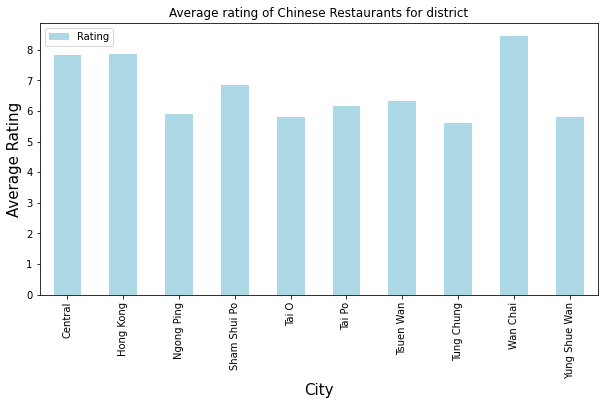

In [24]:
plt.figure(figsize=(10,5))
plt.title('Average rating of Chinese Restaurants for district')
plt.xlabel('District', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_hk.groupby('City').mean()['Rating'].plot(kind='bar', color='lightblue')
plt.legend()
plt.show()

In [25]:
chinese_rest_stats_hk

,City,ID,Name,Likes,Rating,Tips
0,Hong Kong,4b67b864f964a520f15b2be3,Liu Yuan Pavilion (留園雅敘),35.0,8.2,24.0
1,Hong Kong,4bb2cdfb715eef3b41bf85bb,Trusty Congee King (靠得住粥麵小館),30.0,7.5,17.0
2,Tsuen Wan,4d400e3789616dcb823f00b5,Nice Capital Restaurant (麗都讌客),6.0,6.6,2.0
3,Tsuen Wan,4be40308b02ec9b684c450c0,Sportful Garden Restaurant (陶源酒家),6.0,6.2,4.0
4,Tsuen Wan,4e33f15062e1733d7aa708c4,The Great Restaurant (一品雞煲火鍋),13.0,6.2,3.0
5,Tung Chung,4d16c7aab15cb1f737efaf21,Super Super 一粥麵,7.0,5.6,0.0
6,Tung Chung,4c936bcd1221b1f768cf19e2,Federal Palace (Federal Palace 聯邦皇宮),36.0,5.6,22.0
8,Tai Po,4e89b10d6c25bf8636514f83,China House (家傳滬曉),4.0,6.2,5.0
9,Tai Po,4bf0eb5fb315c9b6c97f93ff,Kwan Kee (群記清湯腩),7.0,6.1,11.0
12,Yung Shue Wan,4bc307e84cdfc9b613be9621,Lung Kong Restaurant (龍江川粵菜館),6.0,5.8,10.0


In [26]:
hk_neighborhood_stats=pd.merge(chinese_rest_stats_hk,myhk_df, on='City')
#hk_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
hk_neighborhood_stats

,City,ID,Name,Likes,Rating,Tips,Coordinates,Latitude,Longitude
0,Hong Kong,4b67b864f964a520f15b2be3,Liu Yuan Pavilion (留園雅敘),35.0,8.2,24.0,"22.27832, 114.17469",22.27832,114.17469
1,Hong Kong,4bb2cdfb715eef3b41bf85bb,Trusty Congee King (靠得住粥麵小館),30.0,7.5,17.0,"22.27832, 114.17469",22.27832,114.17469
2,Tsuen Wan,4d400e3789616dcb823f00b5,Nice Capital Restaurant (麗都讌客),6.0,6.6,2.0,"22.37137, 114.11329",22.37137,114.11329
3,Tsuen Wan,4be40308b02ec9b684c450c0,Sportful Garden Restaurant (陶源酒家),6.0,6.2,4.0,"22.37137, 114.11329",22.37137,114.11329
4,Tsuen Wan,4e33f15062e1733d7aa708c4,The Great Restaurant (一品雞煲火鍋),13.0,6.2,3.0,"22.37137, 114.11329",22.37137,114.11329
5,Tung Chung,4d16c7aab15cb1f737efaf21,Super Super 一粥麵,7.0,5.6,0.0,"22.28783, 113.94243",22.28783,113.94243
6,Tung Chung,4c936bcd1221b1f768cf19e2,Federal Palace (Federal Palace 聯邦皇宮),36.0,5.6,22.0,"22.28783, 113.94243",22.28783,113.94243
7,Tai Po,4e89b10d6c25bf8636514f83,China House (家傳滬曉),4.0,6.2,5.0,"22.45007, 114.16877",22.45007,114.16877
8,Tai Po,4bf0eb5fb315c9b6c97f93ff,Kwan Kee (群記清湯腩),7.0,6.1,11.0,"22.45007, 114.16877",22.45007,114.16877
9,Yung Shue Wan,4bc307e84cdfc9b613be9621,Lung Kong Restaurant (龍江川粵菜館),6.0,5.8,10.0,"22.22623, 114.11241",22.22623,114.11241


In [27]:
address = 'Hong Kong'

geolocator = Nominatim(user_agent="hk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hong Kong are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hong Kong are 22.350627, 114.1849161.


In [39]:
hk_neighborhood_stats_rating.head()

,Neighborhood,Average Rating,Average Likes,Average Tips,Label
0,Central,7.825,74.25,28.25,"Central, (7.825)"
1,Hong Kong,7.850,32.50,20.50,"Hong Kong, (7.85)"
2,Ngong Ping,5.900,22.00,8.00,"Ngong Ping, (5.9)"
3,Sham Shui Po,6.850,7.00,4.50,"Sham Shui Po, (6.85)"
4,Tai O,5.800,4.00,2.00,"Tai O, (5.8)"


In [50]:
myhk_df2 =pd.merge(myhk_df,hk_neighborhood_stats_rating, on='City')
myhk_df2['Label']=myhk_df2['City']+', '+'('+ myhk_df2['Average Rating'].map(str)+')'
myhk_df2

,City,Coordinates,Latitude,Longitude,Average Rating,Average Likes,Average Tips,Label
0,Hong Kong,"22.27832, 114.17469",22.27832,114.17469,7.850000,32.500000,20.50,"Hong Kong, (7.85)"
1,Tsuen Wan,"22.37137, 114.11329",22.37137,114.11329,6.333333,8.333333,3.00,"Tsuen Wan, (6.333333333333333)"
2,Tung Chung,"22.28783, 113.94243",22.28783,113.94243,5.600000,21.500000,11.00,"Tung Chung, (5.6)"
3,Tai Po,"22.45007, 114.16877",22.45007,114.16877,6.150000,5.500000,8.00,"Tai Po, (6.15)"
4,Yung Shue Wan,"22.22623, 114.11241",22.22623,114.11241,5.800000,5.000000,7.50,"Yung Shue Wan, (5.8)"
5,Ngong Ping,"22.25556, 113.90391",22.25556,113.90391,5.900000,22.000000,8.00,"Ngong Ping, (5.9)"
6,Tai O,"22.25515, 113.86309",22.25515,113.86309,5.800000,4.000000,2.00,"Tai O, (5.8)"
7,Central,"22.28299, 114.15846",22.28299,114.15846,7.825000,74.250000,28.25,"Central, (7.825)"
8,Wan Chai,"22.28142, 114.17258",22.28142,114.17258,8.450000,37.500000,20.50,"Wan Chai, (8.45)"
9,Sham Shui Po,"22.33023, 114.15945",22.33023,114.15945,6.850000,7.000000,4.50,"Sham Shui Po, (6.85)"


In [54]:
# create map
map_hk = folium.Map(location=[latitude, longitude], zoom_start=10.25)

for lat, lng, city,label in zip(myhk_df2['Latitude'],myhk_df2['Longitude'],myhk_df2['City'],myhk_df2['Label']):
    label = '{}'.format(label)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hk)  
       
map_hk 

## Result, Conclusion and Limitation
In Hong Kong, Central and Wan Chai has relative high rate chinese restaurants in average. Duddell's (都爹利會館) and One Harbour Road (港灣壹號) obtains the highest number of likes and rating among the restaurants in Hong Kong, according to the database of Foursquares. 

To summarize, it would be great to have a visit to Central and Wanchai for good Chinese restaurants. 

As an investor, it would be a bit risky and competitive to start a Chinese restaurants in Central and Wan Chai without any experience. To have the best shot of success, it is suggested to open a Chinese restaurant in Tsuen Wan or Sham Shui Po. These districts have neighborhoods with average ratings exceeding 6.0 and less chinese restaurants than Central and Wanchai, making competition easier.

To conclude, the above analysis is based on the limited resources and data from Foursquares, which is not fully explaining the distribution and performance of restaurants in Hong Kong. The accuracy of data from Foursquares would determine the value of this analysis. It is recommended to have a comprehensive research and analysis with more data from external databases.
